## XGBoost Model Training

### 1. Importing libraries

In [1]:
import numpy
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
import joblib
import scipy.stats as stats
import datetime as dt

### 2. Prepare dataset 

#### Read cleaned dataset

In [2]:
xg_df = pd.read_csv('../data/final_data_2010_2021.csv')
print(xg_df)

                   DATETIME  TOTALDEMAND  TEMPERATURE  HOLIDAY  SUMMER  \
0       2010-01-01 00:00:00      8038.00         23.1        1       1   
1       2010-01-01 00:30:00      7809.31         22.9        1       1   
2       2010-01-01 01:00:00      7483.69         22.6        1       1   
3       2010-01-01 01:30:00      7117.23         22.5        1       1   
4       2010-01-01 02:00:00      6812.03         22.5        1       1   
...                     ...          ...          ...      ...     ...   
196507  2021-03-17 21:30:00      7503.12         19.7        0       0   
196508  2021-03-17 22:00:00      7419.77         19.7        0       0   
196509  2021-03-17 22:30:00      7417.91         19.5        0       0   
196510  2021-03-17 23:00:00      7287.32         19.1        0       0   
196511  2021-03-17 23:30:00      7172.39         18.8        0       0   

        AUTUMN  WINTER  SPRING  MONTH  DAYOFWEEK  WEEKDAY  HOUR  PEAK  
0            0       0       0      1  

#### Set date range used for model build

XGBoost will be trained and tested on below time frame. The remainder of the dataset beyond 2021-02-28 will be used for forecast

In [3]:
model_start = dt.date(2018, 3, 1) #  '2018-03-01'
model_end =  dt.date(2021, 2, 28) # '2021-02-28'

#### Following additional data preperation activities done for XGBosst model

* Convert DATETIME column to DateTime format
* Create new column containing HOUR
* Create COS_HOUR column with the formula, $cos\_hour = \cos(2 * \pi * (hour / 24)) $
* Create 3 lags with window of 1 (as per partial autocorrelation found in EDA)
* Set DATETIME as index
* Drop unused columns
* Filter dataset to be used for model training and testing


In [4]:
# convert to datetime data type
xg_df["DATETIME"] = pd.to_datetime(xg_df['DATETIME'], format='%Y-%m-%d %H:%M:%S')
# derive hour
xg_df["HOUR"] = xg_df["DATETIME"].dt.hour
# derive cos_hour
xg_df["COS_HOUR"] = np.cos(2 * np.pi * xg_df['HOUR'] / 24)
# derive lags
xg_df['lag_1'] = xg_df["TOTALDEMAND"].shift(1)
xg_df['lag_2'] = xg_df["TOTALDEMAND"].shift(2)
xg_df['lag_3'] = xg_df["TOTALDEMAND"].shift(3)
# set index
xg_df.set_index('DATETIME', inplace=True)
# drop columns
xg_df.drop(columns=["DAYOFWEEK", "WEEKDAY","PEAK","HOUR"],inplace=True)
  
# Filter dataset by date range
xg_mdl_df = xg_df[(xg_df.index.date >= model_start) & (xg_df.index.date <= model_end)]

print(xg_mdl_df)

                     TOTALDEMAND  TEMPERATURE  HOLIDAY  SUMMER  AUTUMN  \
DATETIME                                                                 
2018-03-01 00:00:00      7450.05         21.1        0       0       1   
2018-03-01 00:30:00      7292.21         21.4        0       0       1   
2018-03-01 01:00:00      7044.51         22.3        0       0       1   
2018-03-01 01:30:00      6683.37         21.8        0       0       1   
2018-03-01 02:00:00      6555.82         21.2        0       0       1   
...                          ...          ...      ...     ...     ...   
2021-02-28 21:30:00      7870.47         22.8        0       1       0   
2021-02-28 22:00:00      7675.40         22.9        0       1       0   
2021-02-28 22:30:00      7527.73         22.6        0       1       0   
2021-02-28 23:00:00      7301.00         22.2        0       1       0   
2021-02-28 23:30:00      7163.21         21.9        0       1       0   

                     WINTER  SPRING  

#### Split features to explanatory and response and 

Y - "TOTALDEMAND" response variable which we are trying to predict.

X - Explanatory variables. All columns in the dataset excluding "TOTALDEMAND" 


In [5]:
Y = xg_mdl_df["TOTALDEMAND"]
X = xg_mdl_df.drop(columns=["TOTALDEMAND"])

#### Split dataset for Training and Test

We are using 80:20 split. 80% for training and 20% for testing. The split is done chronlogically the newest  20% of data will be used for testing and oldest 80% for training

In [6]:
train_size = int(len(X)*0.8)

X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

An illustration is provided below

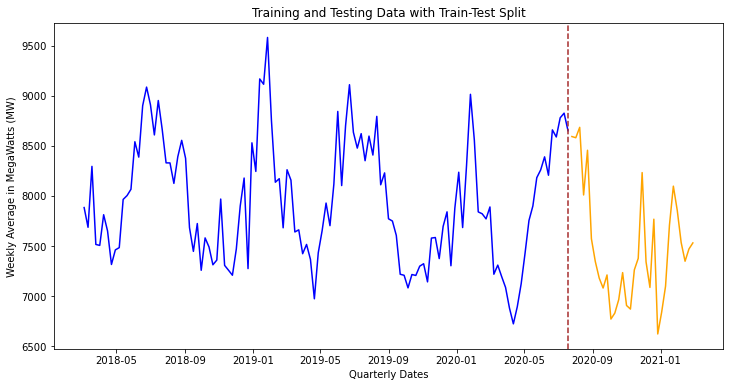

In [7]:
date_train = pd.date_range(start='2018-03-01', end='2020-07-24', freq='W')

train_weeks = np.array_split(Y_train,125)
train_w_average = [round(chunk.mean(),2) for chunk in train_weeks]

date_test = pd.date_range(start='2020-07-24', end='2021-02-28', freq='W')
test_weeks = np.array_split(Y_test,32)
test_w_average = [round(chunk.mean(),2) for chunk in test_weeks]


split_train_end= date_train[-1]
split_test_begin= date_test[0]


plt.figure(figsize=(12,6))
plt.plot(date_train,train_w_average,label='Training data',color='blue')
plt.plot(date_test,test_w_average,label='Testing data',color='orange')
plt.axvline(split_train_end,color='brown',linestyle='--')
plt.xlabel("Quarterly Dates")
plt.ylabel("Weekly Average in MegaWatts (MW)")
plt.title('Training and Testing Data with Train-Test Split');

### 3. Model Build

#### XGBoost modelling 

Set Hyperparameter values to tune

In [8]:
xg_model = xgb.XGBRegressor(objective='reg:squarederror',random_state=24)

parameters = {
    'n_estimators':[100,200,300,500],
    'learning_rate':[0.01,0.05,0.1,0.3],
    'max_depth':[3,5,7,10],
    'gamma':[0,0.1,0.3]
    #'subsample':[0.6,0.8,1],
    #'colsample_bytree': [0.6,0.8,1],
    # 'min_child_weight':[1,3,4,10],
    #'reg_alpha':[0.5]
}

TimeSeriesSplit is a function to cross validate cells 

In [9]:
tsplit = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(estimator=xg_model, param_distributions=parameters, n_iter=50,
                                   scoring='neg_mean_squared_error', cv=tsplit, verbose=1, n_jobs=-1, random_state=42)

#### Identify the best parameters after random search

In [10]:
random_search.fit(X_train,Y_train)
print(random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.3}


#### Predict based on Test dataset

In [11]:

demand_pred = random_search.predict(X_test)

### 4. Model Validation
Get the test scores for each fold and convert from negative MSE to positive RMSE

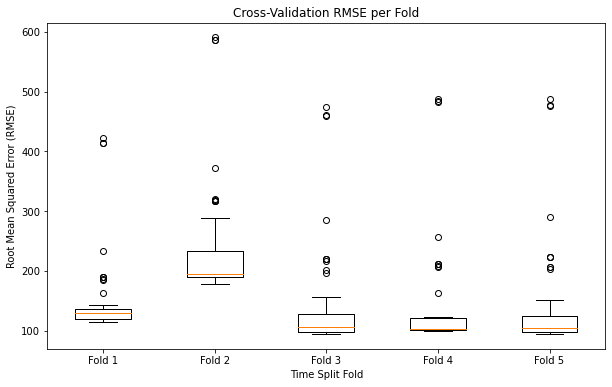

In [12]:
cv_results = random_search.cv_results_
test_scores_mse = cv_results['split0_test_score'], cv_results['split1_test_score'], cv_results['split2_test_score'], cv_results['split3_test_score'], cv_results['split4_test_score']
test_scores_rmse = [np.sqrt(np.abs(score)) for score in test_scores_mse]
plt.figure(figsize=(10, 6))
plt.boxplot(test_scores_rmse, labels=['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'])
plt.title('Cross-Validation RMSE per Fold')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xlabel('Time Split Fold')
plt.show()


###  5. Analyse Model Performance

#### Calculate perfromance metrics

In [13]:
# Calcuate performance metrices 
rmse = round(np.sqrt(mean_squared_error(Y_test,demand_pred)),2)
mae = round(mean_absolute_error(Y_test,demand_pred),2)
mape = round(mean_absolute_percentage_error(Y_test,demand_pred),2)

print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape*100}%")


Root Mean Squared Error: 95.69
Mean Absolute Error: 71.07
Mean Absolute Percentage Error: 1.0%


#### Feature Importance plot

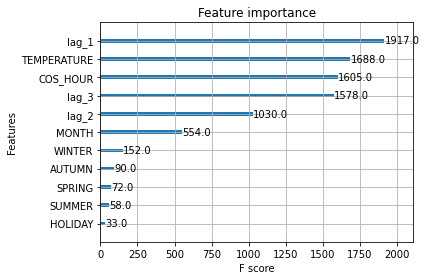

In [14]:
best_model = random_search.best_estimator_
xgb.plot_importance(best_model)
plt.tight_layout()

#### Actual Vs Predicted Value comparison

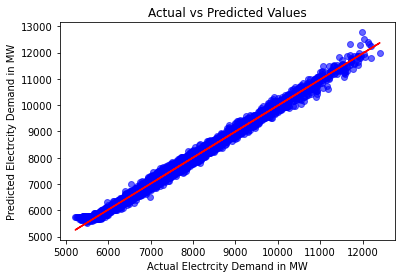

In [15]:
plt.scatter(Y_test, demand_pred, color='blue', label='Predicted vs Actual', alpha=0.6)
slope, intercept = np.polyfit(Y_test,demand_pred,1)
best_line= slope * Y_test + intercept
plt.plot(Y_test, best_line, color='red', label='Best Fit Line')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Electrcity Demand in MW')
plt.ylabel('Predicted Electrcity Demand in MW');


### 6. Compare Model Prediction Accuracy

#### Lets compare the XGBoost model prediction with Actual Demand and AEMO Forecasted demand. Here we use a different date range for comparison.


In [16]:
comp_start_d = dt.date(2021, 3, 1) #  '2021-03-01'
comp_end_d = dt.date(2021, 3, 17) #  '2021-03-17'

#### Filter Actual Demand data

In [17]:
xgb_act_df = xg_df[(xg_df.index.date >= comp_start_d) & (xg_df.index.date <= comp_end_d)]
print(xgb_act_df)

                     TOTALDEMAND  TEMPERATURE  HOLIDAY  SUMMER  AUTUMN  \
DATETIME                                                                 
2021-03-01 00:00:00      7102.38         21.3        0       0       1   
2021-03-01 00:30:00      6947.85         20.7        0       0       1   
2021-03-01 01:00:00      6769.28         20.1        0       0       1   
2021-03-01 01:30:00      6499.29         19.3        0       0       1   
2021-03-01 02:00:00      6336.15         19.3        0       0       1   
...                          ...          ...      ...     ...     ...   
2021-03-17 21:30:00      7503.12         19.7        0       0       1   
2021-03-17 22:00:00      7419.77         19.7        0       0       1   
2021-03-17 22:30:00      7417.91         19.5        0       0       1   
2021-03-17 23:00:00      7287.32         19.1        0       0       1   
2021-03-17 23:30:00      7172.39         18.8        0       0       1   

                     WINTER  SPRING  

#### Predict the values for the date range using the XGBoost Model

In [18]:
xgb_new_pred_df = xgb_act_df.drop(columns=["TOTALDEMAND"])
xgb_new_pred = random_search.predict(xgb_new_pred_df)

#### Load AEMO Forecasted Demand Data

In [19]:
aemo_fd_df = pd.read_csv("../data/forecastdemand_nsw.csv")
aemo_fd_df['DATETIME'] = pd.to_datetime(aemo_fd_df['DATETIME'], format='%Y-%m-%d  %H:%M:%S')
aemo_fd_df.set_index('DATETIME', inplace=True)
aemo_fd_df = aemo_fd_df[(aemo_fd_df.index.date >= comp_start_d) & (aemo_fd_df.index.date <= comp_end_d)]

print(aemo_fd_df)

                     FORECASTDEMAND
DATETIME                           
2021-03-01 00:00:00     6888.226338
2021-03-01 00:30:00     6689.353472
2021-03-01 01:00:00     6482.016301
2021-03-01 01:30:00     6246.177838
2021-03-01 02:00:00     6084.376800
...                             ...
2021-03-17 21:30:00     7396.625303
2021-03-17 22:00:00     7317.702687
2021-03-17 22:30:00     7266.887647
2021-03-17 23:00:00     7173.866522
2021-03-17 23:30:00     7043.236857

[816 rows x 1 columns]


#### Prepare final dataset for comparison

In [20]:
full_data = pd.merge(xgb_act_df, aemo_fd_df, on="DATETIME", how='inner')
full_data = full_data[['TOTALDEMAND','FORECASTDEMAND']]
full_data['XGBPREDICTION'] = xgb_new_pred
print(full_data)

                     TOTALDEMAND  FORECASTDEMAND  XGBPREDICTION
DATETIME                                                       
2021-03-01 00:00:00      7102.38     6888.226338    6996.455078
2021-03-01 00:30:00      6947.85     6689.353472    6962.266113
2021-03-01 01:00:00      6769.28     6482.016301    6749.259277
2021-03-01 01:30:00      6499.29     6246.177838    6530.342773
2021-03-01 02:00:00      6336.15     6084.376800    6319.468750
...                          ...             ...            ...
2021-03-17 21:30:00      7503.12     7396.625303    7419.083496
2021-03-17 22:00:00      7419.77     7317.702687    7426.936523
2021-03-17 22:30:00      7417.91     7266.887647    7344.549316
2021-03-17 23:00:00      7287.32     7173.866522    7284.683594
2021-03-17 23:30:00      7172.39     7043.236857    7158.212891

[816 rows x 3 columns]


#### Plot the data to compare Demand and Forecasts

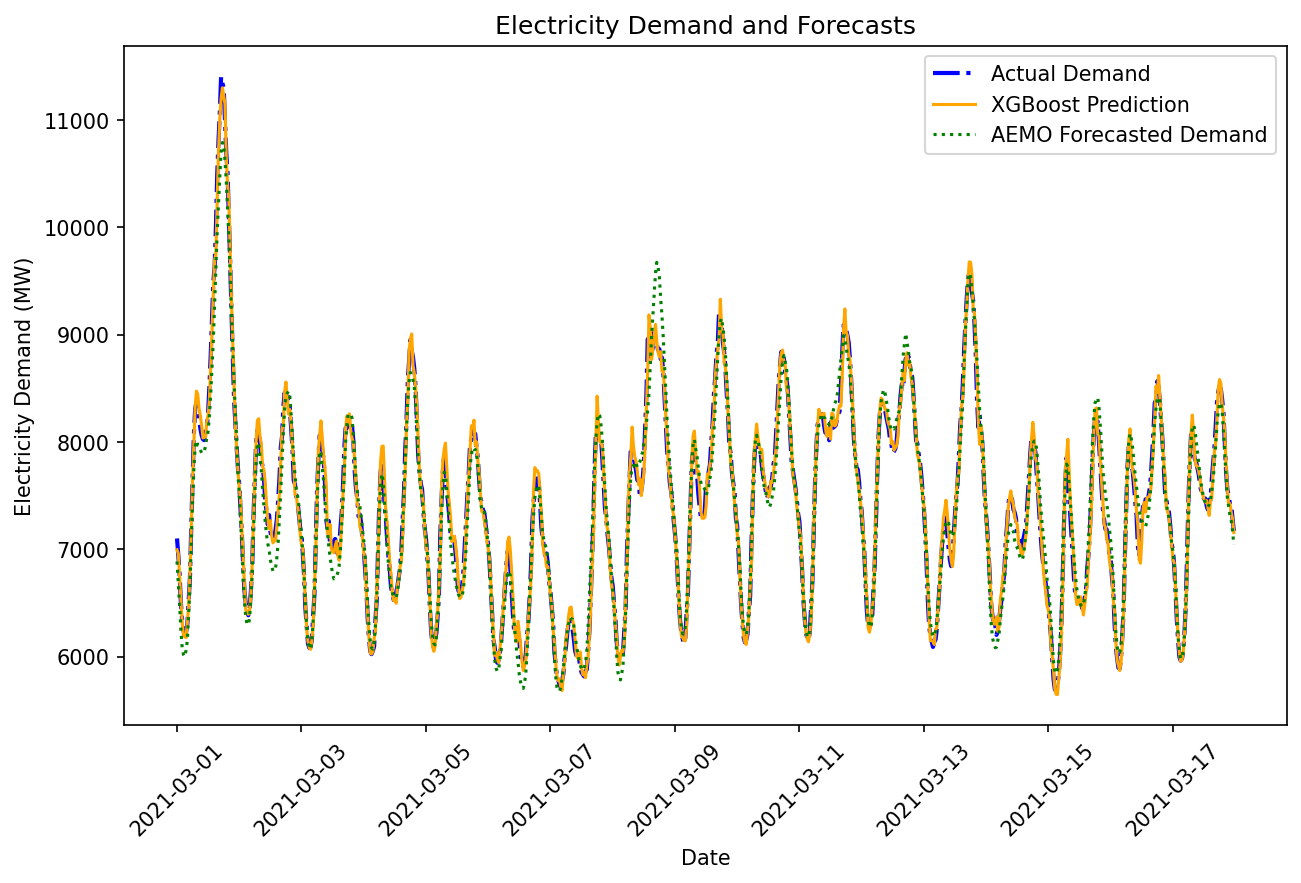

In [21]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(full_data.index, full_data['TOTALDEMAND'], label='Actual Demand', color='blue',linestyle='-.',linewidth=2)
plt.plot(full_data.index, full_data['XGBPREDICTION'], label='XGBoost Prediction', color='orange')
plt.plot(full_data.index, full_data['FORECASTDEMAND'], label='AEMO Forecasted Demand', color='green',linestyle=':')

plt.title('Electricity Demand and Forecasts')
plt.xlabel('Date')
plt.ylabel('Electricity Demand (MW)')

plt.legend()
plt.xticks(rotation=45);

#### Calaculate Performance Matrices 

1. AEMO forecasted demand

In [22]:
AEMO_rmse = round(np.sqrt(mean_squared_error(full_data["TOTALDEMAND"],full_data["FORECASTDEMAND"])),2)
AEMO_mae = round(mean_absolute_error(full_data["TOTALDEMAND"],full_data["FORECASTDEMAND"]),2)
AEMO_mape = round(mean_absolute_percentage_error(full_data["TOTALDEMAND"],full_data["FORECASTDEMAND"]),2)

print(f"RMSE: {AEMO_rmse}")
print(f"MAE: {AEMO_mae}")
print(f"MAPE: {AEMO_mape*100}%")

RMSE: 173.61
MAE: 131.69
MAPE: 2.0%


2. XGBoost Predicted Demand

In [23]:
XGBST_rmse = round(np.sqrt(mean_squared_error(full_data["TOTALDEMAND"],full_data["XGBPREDICTION"])),2)
XGBST_mae = round(mean_absolute_error(full_data["TOTALDEMAND"],full_data["XGBPREDICTION"]),2)
XGBST_mape = round(mean_absolute_percentage_error(full_data["TOTALDEMAND"],full_data["XGBPREDICTION"]),2)

print(f"RMSE: {XGBST_rmse}")
print(f"MAE: {XGBST_mae}")
print(f"MAPE: {XGBST_mape*100}%")

RMSE: 88.13
MAE: 67.04
MAPE: 1.0%


#### Write the combined dataset 

In [24]:
full_data.to_csv("../results/xgb_aemo_predictions.csv") 